In [8]:
import sys
sys.path.append("./source")

# libraries for this project
import train_lmmNet
import predict_lmmNet
import lorenz
from utils import *
import train_onestep

import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint

# 1. LmmNet on Lorenz system

The [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) is a system of three ODEs having chaotic solutions (butterfly effect). We start with the initial conditions (-8, 7, 27).

$$\begin{split} \dot{x} & = \sigma (y - x) \\
\dot{y} & = x (\rho - z) - y \\
\dot{z} & = xy - \beta z
\end{split}$$

We will train both one-step method and LmmNet on data and compare the results.

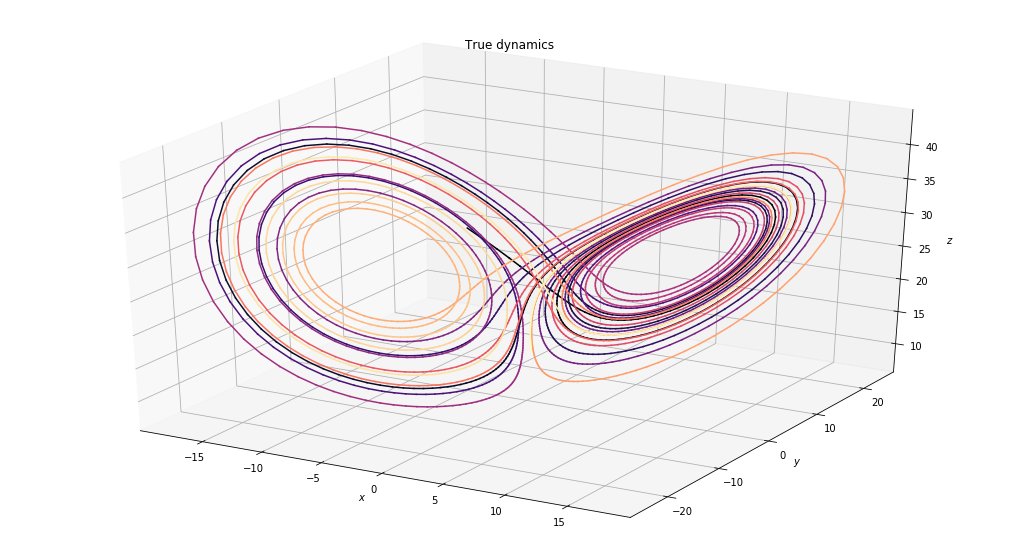

In [2]:
time_points, lorenz_data = lorenz.simulate_default()

# plot phase portrait in 3-D projection

x = lorenz_data[0,:,0]
y = lorenz_data[0,:,1]
z = lorenz_data[0,:,2]

fig = plt.figure(figsize=(18,10)) # twice as wide as it is tall
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(0, len(x)):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.magma(int(255*i/len(x))))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('True dynamics', fontsize = 12, loc='center', pad=2.0)
plt.show()

In [5]:
# train LmmNet

net = train_lmmNet.train_easy(time_points, lorenz_data)

x0 = lorenz_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, net), x0, time_points)

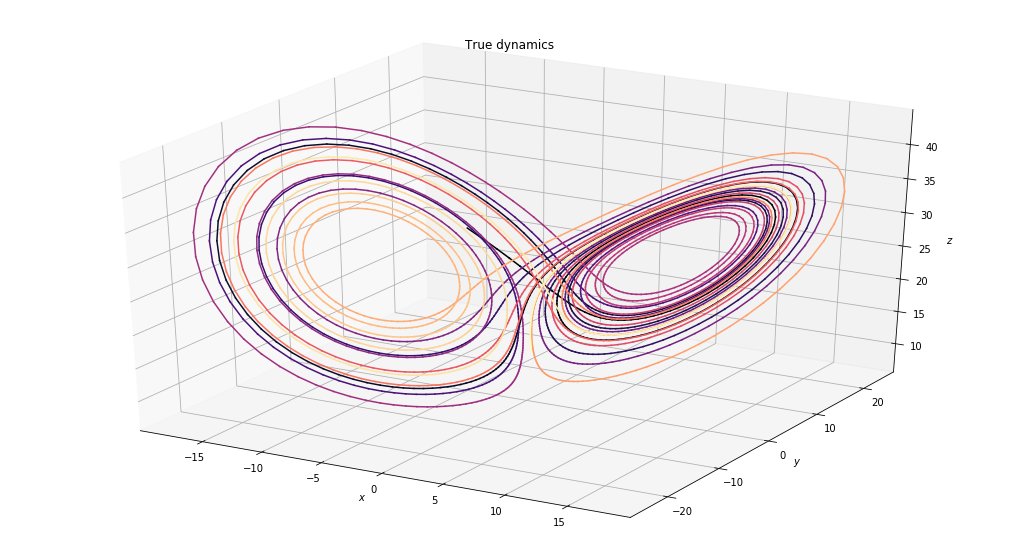

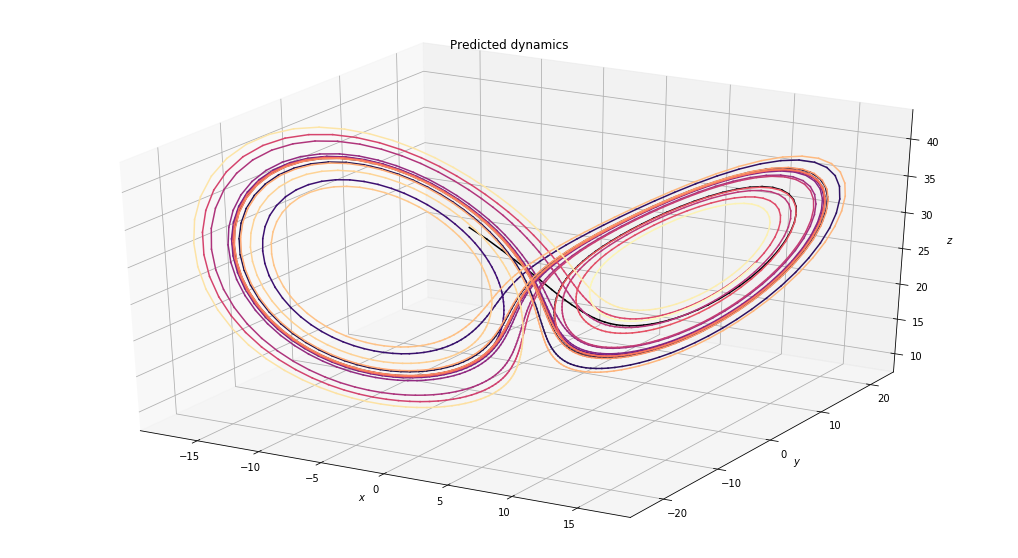

In [7]:
# plot the trajectories in phase portrait
# real data as dots
# predicted trajectories as lines

x = lorenz_data[0,:,0]
y = lorenz_data[0,:,1]
z = lorenz_data[0,:,2]

fig = plt.figure(figsize=(18,10)) # twice as wide as it is tall
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(0, len(x)):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.magma(int(255*i/len(x))))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('True dynamics', fontsize = 12, loc='center', pad=2.0)


x = predicted_traj[:,0]
y = predicted_traj[:,1]
z = predicted_traj[:,2]

fig = plt.figure(figsize=(18,10)) # twice as wide as it is tall
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(0, len(x)):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.magma(int(255*i/len(x))))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('LmmNet Predicted dynamics', fontsize = 12, loc='center', pad=2.0)

plt.show()

The trajectory of our solution in the phase space: the color goes from dark to bright as time progresses.

**compare this to wikipedia**

A sample trajectory through phase space is plotted near a Lorenz attractor with σ = 10, ρ = 28, β = 8/3. The color of the solution fades from black to blue as time progresses, and the black dot shows a particle moving along the solution in time. Initial conditions: x(0) = 0, y(0) = 2, z(0) = 20. 0 < t < 35. The 3-dimensional trajectory {x(t), y(t), z(t)} is shown from different angles to demonstrate its structure.
![lorenz](https://upload.wikimedia.org/wikipedia/commons/1/13/A_Trajectory_Through_Phase_Space_in_a_Lorenz_Attractor.gif)
As we can see, the predicted dynamics still captures the form of the attractor, but small differences between the exact and learnt model grow exponentially due to the chaotic nature. This is why the errors are small only for short period T. However, the bistability of the attractor is correctly predicted.

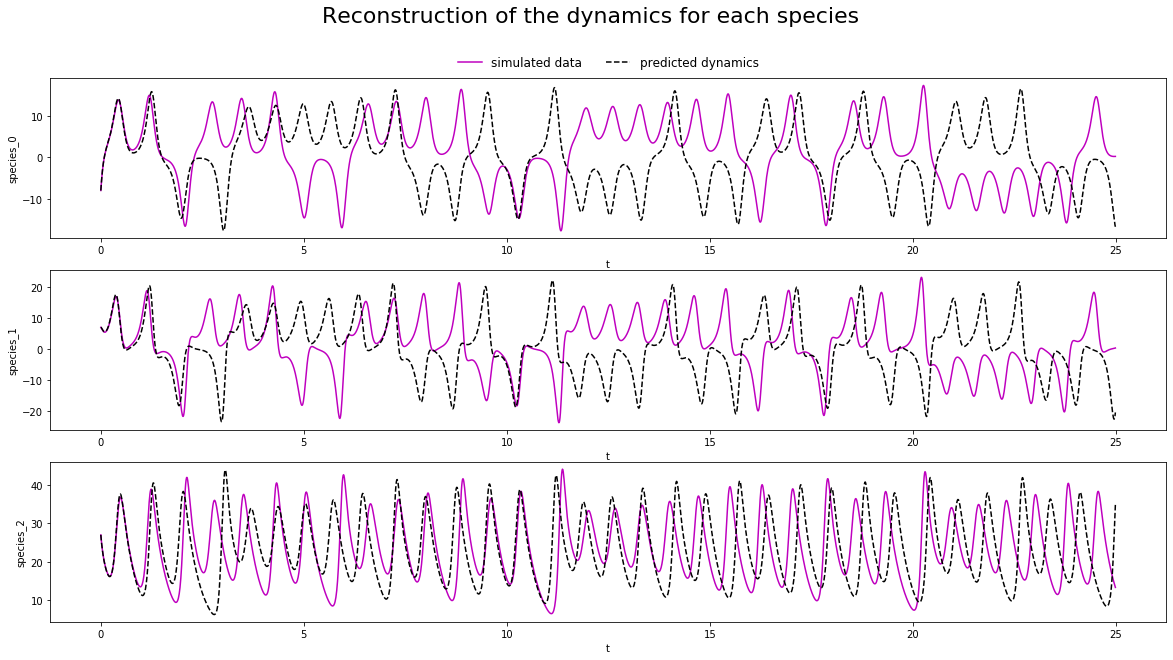

In [4]:
#time_points = lorenz['t']

t0 = 0 # start time
T = 25 # end time
h = 0.01 # step size

# generate data
time_points = np.arange(t0, T, h)

plt.figure(figsize=(20, 10))
plt.suptitle("Reconstruction of the dynamics for each species", fontsize=22)

# plot the dynamics with time
for species in range(3):
    plt.subplot(3, 1, species + 1)
    plt.plot(time_points, lorenz['data'][0,:,species], 'm-', label='simulated data')
    plt.plot(time_points, lorenz['pred'][:,species], 'k--', label='predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('species_' + str(species))

plt.legend(loc='center', bbox_to_anchor=(0.5, 3.5), ncol=2, fontsize=12, frameon=False)
plt.show()

# 2. One step learning on Lorenz system

In [9]:
# create data for onestep method
feature_list = []
target_list = ['x_component', 'y_component', 'z_component']
df = create_data(lorenz_data, time_points, cols=target_list)
print("Shape of the tensor is: ", lorenz_data.shape)

Shape of the dataframe is: (2500, 4)
Shape of the tensor is:  (1, 2500, 3)


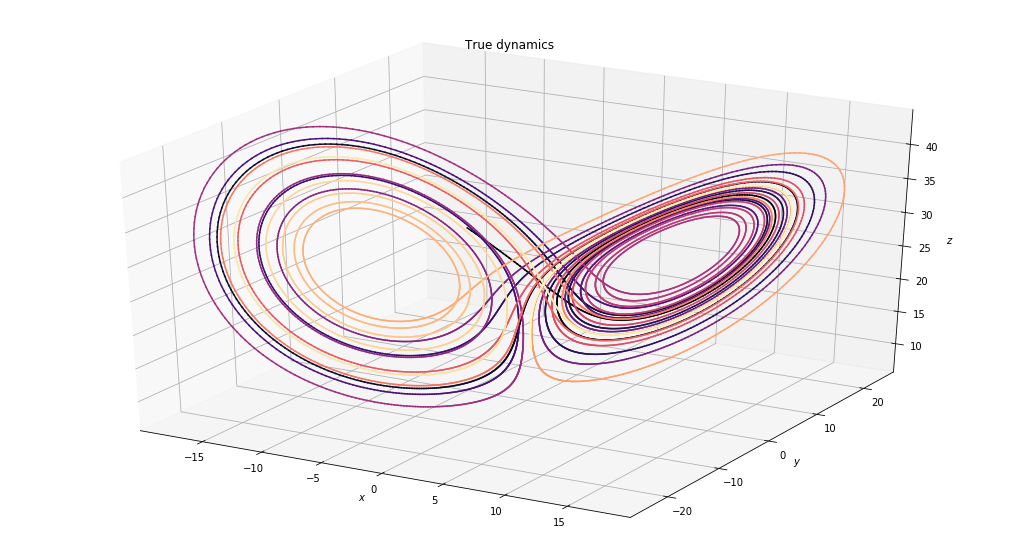

In [13]:
# create training data
df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=10000)

# plot phase portrait in 3-D projection

x = df_train[('feature', 'x_component')].values
y = df_train[('feature', 'y_component')].values
z = df_train[('feature','z_component')].values

fig = plt.figure(figsize=(18,10)) # twice as wide as it is tall
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(0, len(x)):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.magma(int(255*i/len(x))))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('True dynamics', fontsize = 12, loc='center', pad=2.0)
plt.show()

x_component


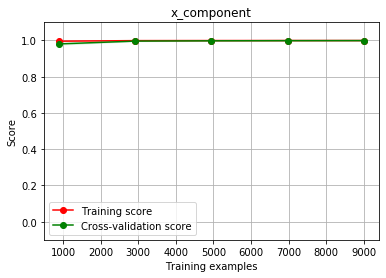

Target: x_component, CV Pearson R2 coefficient: 0.999872
y_component


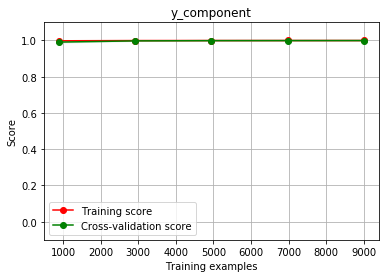

Target: y_component, CV Pearson R2 coefficient: 0.999929
z_component


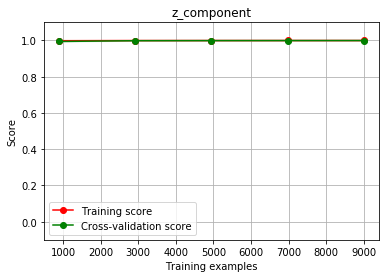

Target: z_component, CV Pearson R2 coefficient: 0.999912
Average training score: 0.9999041756104434
x_component RMSE: -0.00756619407291939 standard deviation: 0.4903556727532791


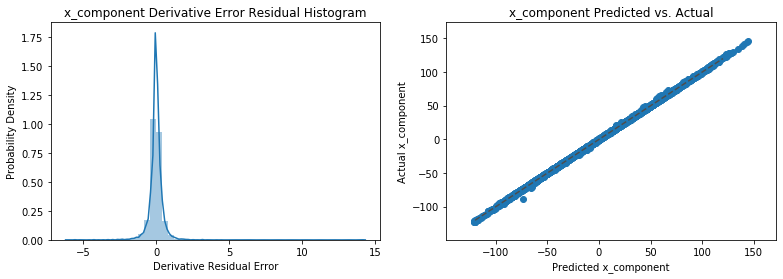

y_component RMSE: -0.0015962777949406566 standard deviation: 0.5519804395343831


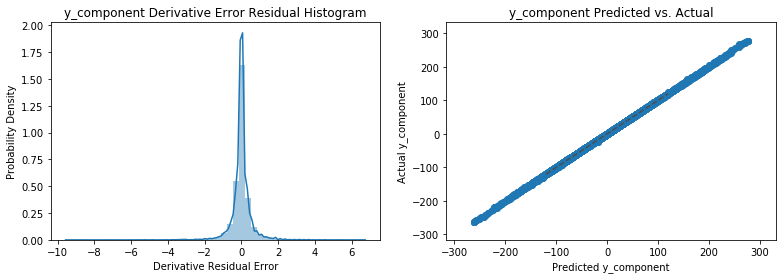

z_component RMSE: -0.030910905333747626 standard deviation: 0.744092447786607


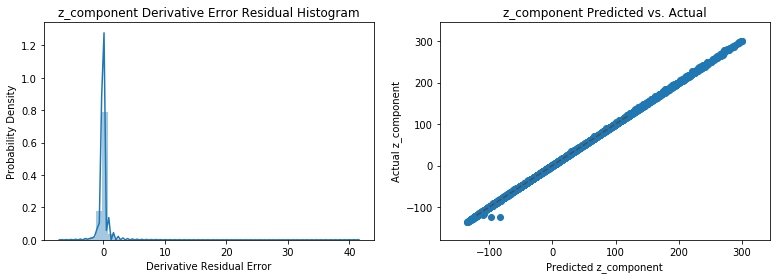

Total Derivative Mean Error: 0.8386883992135575 Error Standard Deviation: 0.6637294959150623


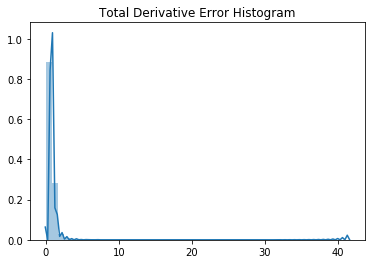

Real data:


,x_component,y_component,z_component
Strain,,,
0,-8.000000,7.000000,27.000000
0,-6.581023,6.814745,25.793150
0,-5.317130,6.585408,24.721766
0,-4.196173,6.343043,23.768497
0,-3.204675,6.109339,22.916338
...,...,...,...
0,0.240699,0.209376,14.716846
0,0.239169,0.239433,14.330114
0,0.240672,0.270104,13.953631


Predicted data:


,x_component,y_component,z_component
Time,,,
0.00,-8.000000,7.000000,27.000000
0.01,-6.585266,6.818381,25.998364
0.02,-5.311580,6.622092,24.926154
0.03,-4.183763,6.406521,23.958662
0.04,-3.165208,6.201158,23.091066
...,...,...,...
24.95,-5.434536,-2.006530,27.723582
24.96,-5.140406,-2.014386,27.090744
24.97,-4.867635,-2.050665,26.468499


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 61.542051673907665 RMSE percentage: 183.35362018207442
ML Fit: y_component 69.60561971731119 RMSE percentage: 219.12891931253884
ML Fit: z_component 51.04880034847419 RMSE percentage: 62.53584714936107
ML model aggregate error
Average RMSE: 60.73215724656435
Total percentage error: 155.00612888132477


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


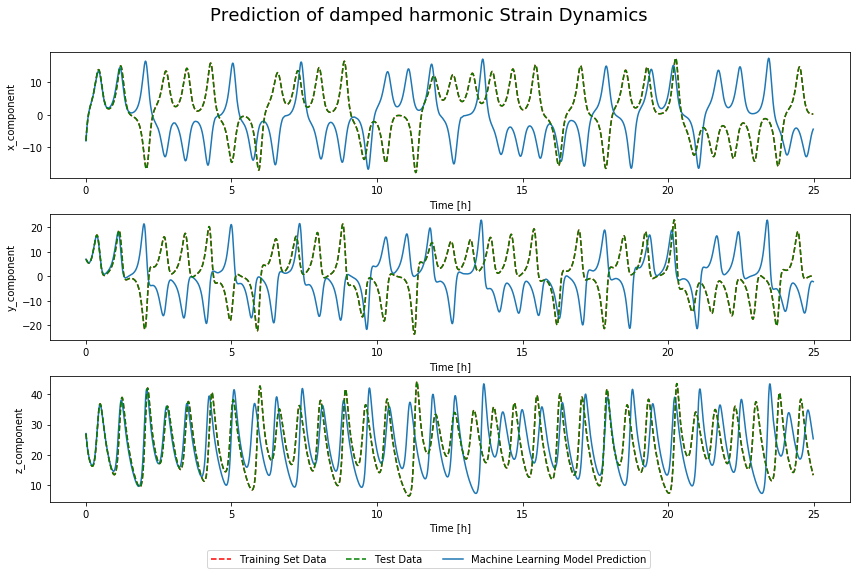

In [14]:
tp, pred = end_to_end_training(df, df_train, df, feature_list, target_list, (3,1))

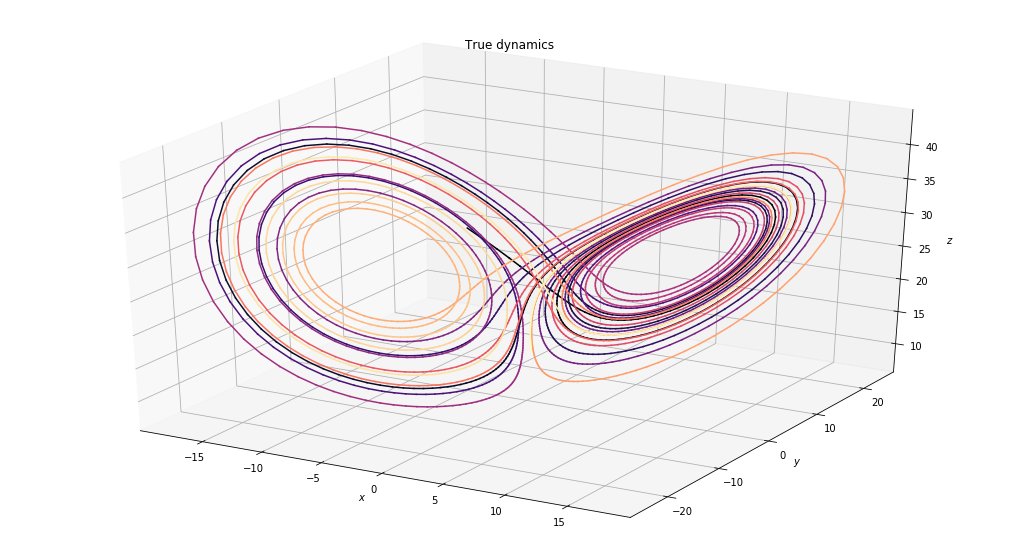

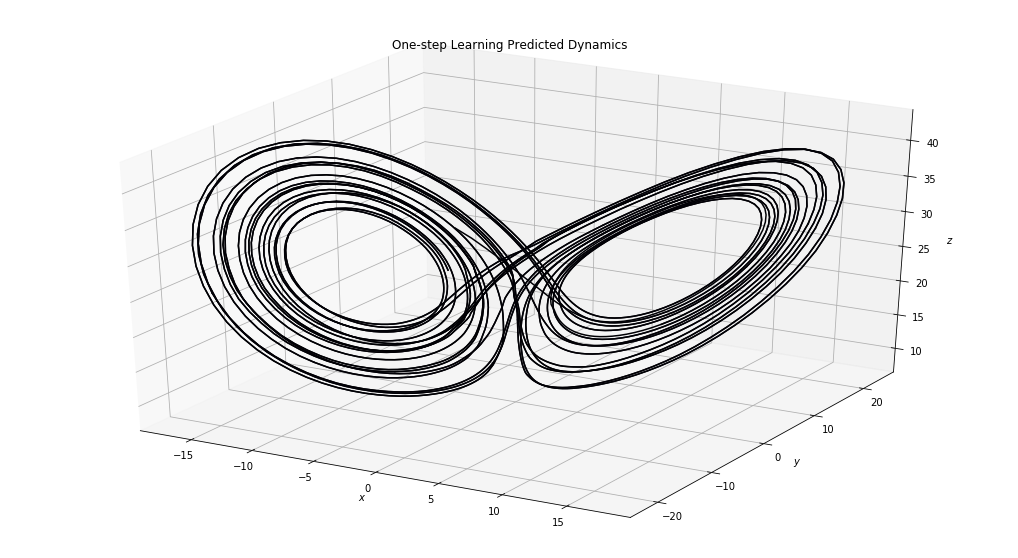

In [16]:
# plot the trajectories in phase portrait
# real data as dots
# predicted trajectories as lines

x = lorenz_data[0,:,0]
y = lorenz_data[0,:,1]
z = lorenz_data[0,:,2]

fig = plt.figure(figsize=(18,10)) # twice as wide as it is tall
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(0, len(x)):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.magma(int(255*i/len(x))))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('True dynamics', fontsize = 12, loc='center', pad=2.0)


x = pred.iloc[:,0]
y = pred.iloc[:,1]
z = pred.iloc[:,2]

fig = plt.figure(figsize=(18,10)) # twice as wide as it is tall
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(0, len(x)):
    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.magma(int(255*i/len(x))))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('One-step Learning Predicted Dynamics', fontsize = 12, loc='center', pad=2.0)

plt.show()